In [6]:
# Instalar Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Descargar e instalar Spark (enlace actualizado)
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Instalar pyspark
!pip install -q pyspark

import os

# Configurar las variables de entorno
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

from pyspark.sql import SparkSession

# Iniciar sesión de Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Verificar que Spark está funcionando
spark

# Verificar la versión de Spark
spark.version

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/DM_DCCF/top_podcast.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
#filtrar episodios explícitos
df_filtered = df.filter(df['explicit'] == True)
df_filtered.show()

#filtrar por región MX
df_filtered = df.filter(df['region'] == 'mx')
df_filtered.show()

#filtrar episodios del último año
df_filtered = df.filter(df['releasedate'] > '2024-01-01')
df_filtered.show()

#Contar episodios tienen un rank menor a 100
df.filter(df['rank'] < 100).count()

#Crear una columna que sea True si la duración del episodio es mayor a 30 minutos, y False de lo contrario:
from pyspark.sql import functions as F
df = df.withColumn('long_episode', F.when(df['durationms'] > 1800000, True).otherwise(False))
df.show()


#Promedio y valor máximo de rank por región
df.groupBy('region').agg(F.mean('rank').alias('mean_rank'),
                         F.max('rank').alias('max_rank')).show()

#distribución de frecuencias por categoría
df.groupBy('region').count().orderBy('count', ascending=False).show()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+----------+----+------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------+--------------------+-----------+--------+---------+-----------+------------+--------------------+------------------------+-------------+------------------+
|      date|rank|region|chartRankMove|          episodeUri|             showUri|         episodeName|         description|            showname|     showdescription|durationms|explicit|is_externally_hosted|is_playable|language|languages|releasedate|showexplicit|            showhref|showis_externally_hosted|showmediatype|showtotal_episodes|
+----------+----+------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------+-----

In [7]:
#RDDs
rdd = df.rdd

# Operaciones en el RDD:
# estadística desccriptiva para duracion de los podcasts:
duration_rdd = rdd.map(lambda row: row["durationms"]) \
                  .filter(lambda x: x is not None) \
                  .filter(lambda x: x.isdigit()) \
                  .map(lambda x: int(x))

count = duration_rdd.count()
total_duration = duration_rdd.reduce(lambda x, y: x + y)
mean_duration = total_duration / count

min_duration = duration_rdd.min()
max_duration = duration_rdd.max()

print(f"Count: {count}")
print(f"Mean Duration: {mean_duration}")
print(f"Min Duration: {min_duration}")
print(f"Max Duration: {max_duration}")

# conteo de episodios explícitos y no-explícito
explicit_count = rdd.filter(lambda row: row["explicit"] in [True, "TRUE", "TRUE", 1, "1"]).count()

non_explicit_count = rdd.filter(lambda row: row["explicit"] in [False, "FALSE", "FALSE", 0, "0"]).count()

print(f"Explicit Episodes: {explicit_count}")
print(f"Non-Explicit Episodes: {non_explicit_count}")

# datos por región:
region_counts = rdd.map(lambda row: (row["region"], 1)).reduceByKey(lambda x, y: x + y)

# resultados
for region, count in region_counts.collect():
    print(f"Region: {region}, Episode Count: {count}")

Count: 127626
Mean Duration: 3380753.707637942
Min Duration: 6896
Max Duration: 42349156
Explicit Episodes: 19284
Non-Explicit Episodes: 108342
Region: us, Episode Count: 6800
Region: pl, Episode Count: 6800
Region: mx, Episode Count: 6800
Region: jp, Episode Count: 6800
Region: in, Episode Count: 6800
Region: ie, Episode Count: 6800
Region: gb, Episode Count: 6800
Region: fr, Episode Count: 6800
Region: co, Episode Count: 6800
Region: ca, Episode Count: 6800
Region: br, Episode Count: 6800
Region: au, Episode Count: 6800
Region: at, Episode Count: 6800
Region: ar, Episode Count: 6800
Region: ph, Episode Count: 6800
Region: nz, Episode Count: 6800
Region: nl, Episode Count: 6800
Region: it, Episode Count: 6800
Region: id, Episode Count: 6800
Region: es, Episode Count: 6800
Region: de, Episode Count: 6800
Region: cl, Episode Count: 6800


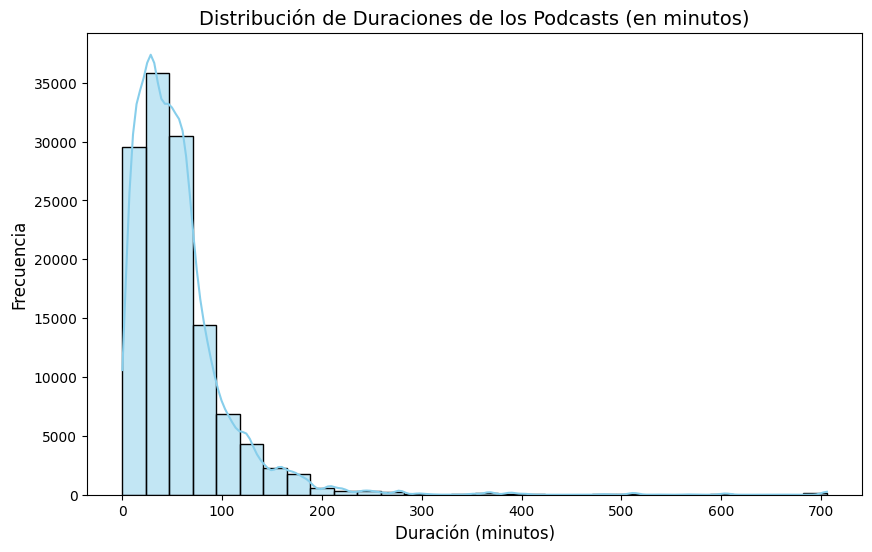

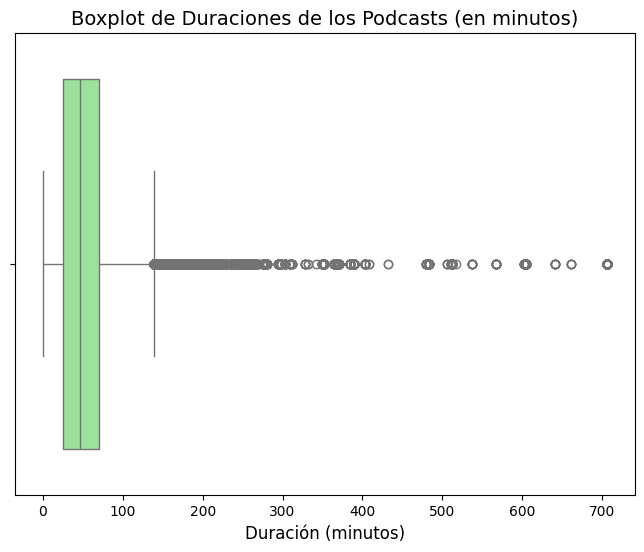

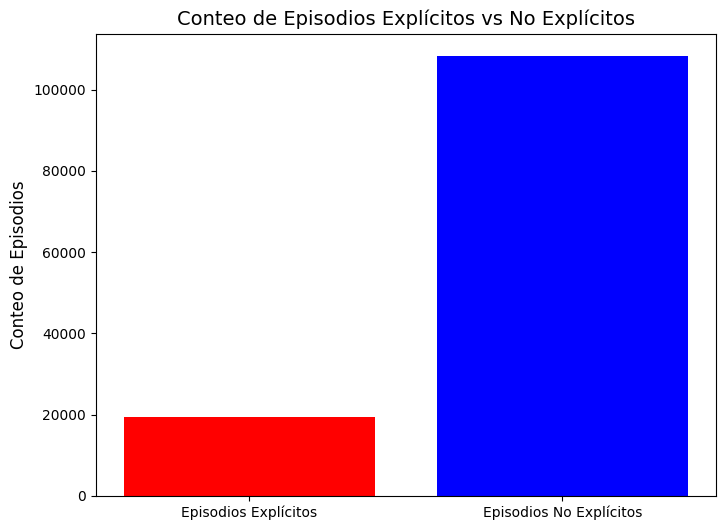

In [8]:
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
# duraciones en una lista
duration_list = duration_rdd.collect()

# Convertir milisegundos a minutos
duration_list_minutes = [d / 60000 for d in duration_list]  # convierte de ms a minutos

# histograma duracion
plt.figure(figsize=(10, 6))
sns.histplot(duration_list_minutes, bins=30, kde=True, color="skyblue")
plt.title('Distribución de Duraciones de los Podcasts (en minutos)', fontsize=14)
plt.xlabel('Duración (minutos)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

#boxplot de duracion para revisar valores atípicos
plt.figure(figsize=(8, 6))
sns.boxplot(x=duration_list_minutes, color="lightgreen")
plt.title('Boxplot de Duraciones de los Podcasts (en minutos)', fontsize=14)
plt.xlabel('Duración (minutos)', fontsize=12)
plt.show()

#episodios explicit vs non explicit
# Datos
explicit_counts = [explicit_count, non_explicit_count]
labels = ['Episodios Explícitos', 'Episodios No Explícitos']

# gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(labels, explicit_counts, color=['red', 'blue'])
plt.title('Conteo de Episodios Explícitos vs No Explícitos', fontsize=14)
plt.ylabel('Conteo de Episodios', fontsize=12)
plt.show()




In [9]:
#convertir fechas usando to_date
from pyspark.sql.functions import to_date, col

# Convertir las fechas usando el formato correcto
df = df.withColumn("date_converted", to_date(col("date"), "dd/MM/yyyy"))

# Mostrar las primeras filas para verificar
df.select("date", "date_converted").show(10, truncate=False)

+----------+--------------+
|date      |date_converted|
+----------+--------------+
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
|02/09/2024|2024-09-02    |
+----------+--------------+
only showing top 10 rows



In [10]:
# Filtrar shows que están en el top 10 en todo el dataset
from pyspark.sql.functions import col

# Filtrar shows que están en el top 10
top_podcasts = (
    df.filter(col("rank") <= 10)
    .groupBy("showname", "showUri", "region")  # Agrupar por showname, showUri y region
    .count()
    .orderBy(col("count").desc())  # Ordenar por la cantidad en orden descendente
)

# Mostrar los resultados
top_podcasts.show(10, truncate=False)

+-----------------------------------+----------------------+------+-----+
|showname                           |showUri               |region|count|
+-----------------------------------+----------------------+------+-----+
|Mishary Rashid Alafasy             |0StCPIsurzmlUZI5eygDaY|id    |97   |
|The Joe Rogan Experience           |4rOoJ6Egrf8K2IrywzwOMk|us    |73   |
|The Joe Rogan Experience           |4rOoJ6Egrf8K2IrywzwOMk|ca    |72   |
|The Joe Rogan Experience           |4rOoJ6Egrf8K2IrywzwOMk|au    |71   |
|Relatos de la Noche                |0SAv0bEYhFndhLODSzPIfL|mx    |71   |
|La Cruda                           |2G0HRZba65w6T9NDNScNK2|ar    |71   |
|The Joe Rogan Experience           |4rOoJ6Egrf8K2IrywzwOMk|nz    |71   |
|Café Com Deus Pai | Podcast oficial|5Yl4ao85LeyLc56nvm1E2T|br    |69   |
|LEGEND                             |4xQ0IUSsrfs6pltTnwr3Kk|fr    |68   |
|Não Inviabilize                    |66XCLKbi33MubYTZX2G2jW|br    |61   |
+-----------------------------------+-

Top 10 Podcasts en México ordenados por promedio de ranking:
+--------------------+------------------+
|             showUri|      average_rank|
+--------------------+------------------+
|7eNqPMFjXfiBxCc3i...|              1.75|
|1gIOIXYHYKdu2osi0...|               2.5|
|0SAv0bEYhFndhLODS...| 6.519607843137255|
|3ixjcmfLVVkIuttAD...| 8.714285714285714|
|4DXL6VEOqdfr3iSVC...|              10.6|
|6hkEJYGZrE5jpSEGA...|12.333333333333334|
|0tjlOmfRVWP7Ls9W9...|12.636363636363637|
|3a36uQneX1imRuopa...|15.980392156862745|
|7sNB9FFvhZuhltnUi...|16.045454545454547|
|28SJgMubejuwrtGJe...|             16.75|
+--------------------+------------------+



<ipython-input-11-e992d1350ffa>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_10_avg_rank_pd, x="average_rank", y="showUri", palette="viridis")


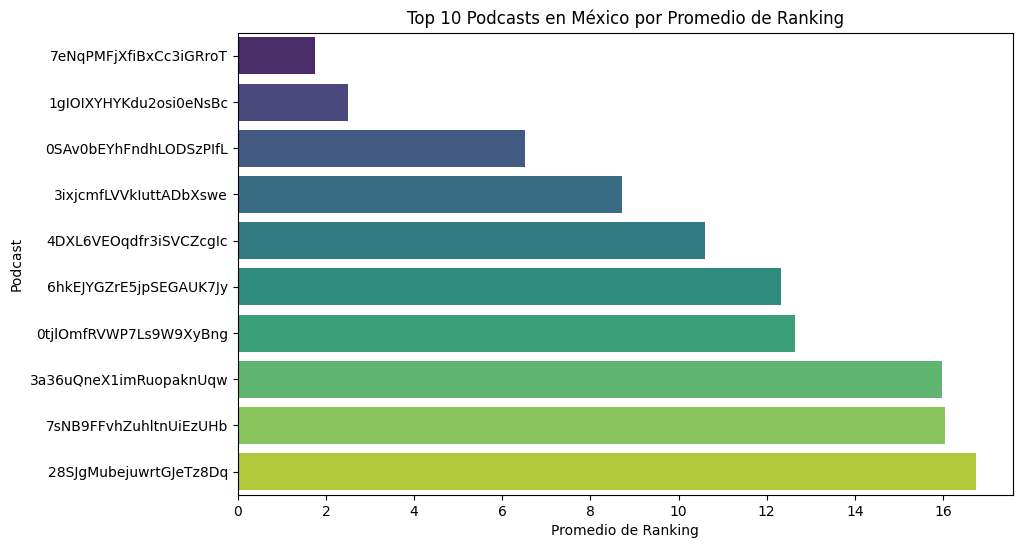

In [11]:
from pyspark.sql.functions import col, to_date, avg

# Filtrar los podcasts por región "MX"
df_mx = df.filter(col("region") == "mx")
df_mx.show
# Calcular el promedio de ranking por pódcast (usando showUri)
df_avg_rank_mx = df_mx.groupBy("showUri").agg(avg("rank").alias("average_rank"))

# Ordenar los podcasts por promedio de ranking
df_avg_rank_mx = df_avg_rank_mx.orderBy(col("average_rank").asc())

# Filtrar el top 10 de podcasts con mejor promedio de ranking
df_top_10_avg_rank = df_avg_rank_mx.limit(10)

print("Top 10 Podcasts en México ordenados por promedio de ranking:")
df_top_10_avg_rank.show()

# Convertir el DataFrame a Pandas para visualizar
df_top_10_avg_rank_pd = df_top_10_avg_rank.toPandas()

# Gráfico del top 10 de podcasts por promedio de ranking
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_10_avg_rank_pd, x="average_rank", y="showUri", palette="viridis")
plt.title("Top 10 Podcasts en México por Promedio de Ranking")
plt.xlabel("Promedio de Ranking")
plt.ylabel("Podcast")
plt.show()

In [12]:
# Buscar el podcast con mejor ranking en mx
show_uri_top = '7eNqPMFjXfiBxCc3iGRroT'

# Filtrar
filtered_showname = df.filter(df['showUri'] == show_uri_top).select('showname')


filtered_showname.show()

+-----------+
|   showname|
+-----------+
| casi algos|
| casi algos|
| casi algos|
| casi algos|
| casi algos|
| casi algos|
| casi algos|
| casi algos|
| casi algos|
+-----------+



In [13]:
from pyspark.sql import functions as F

# showUri más repetido
frequencies = df_mx.groupBy("showUri").agg(F.count("showUri").alias("count"))

# Ordenar y obtener el showUri más repetido
most_frequent = frequencies.orderBy(F.col("count").desc()).first()

# print
print(f"El showUri más repetido en la región 'mx' es: {most_frequent['showUri']}")
print(f"Aparece {most_frequent['count']} veces.")

El showUri más repetido en la región 'mx' es: 6wF969GfLUfypoKaicH5gr
Aparece 102 veces.


In [14]:
# Buscar el podcast que más aparece en el top 200
show_uri_rep = '6wF969GfLUfypoKaicH5gr'

# Filtrar
show_rep = df.filter(df['showUri'] == show_uri_rep).select('showname')

show_rep.show()
df.filter(df['showUri'] == show_uri_rep).count()

+--------------------+
|            showname|
+--------------------+
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
|Leyendas Legendarias|
+--------------------+
only showing top 20 rows



266

In [15]:
# Agrupar por 'showUri' y contar la cantidad de ocurrencias
repetition_count = (
    df_mx.groupBy('showUri')
    .agg(F.count('*').alias('repetition_count'))
    .orderBy(F.col('repetition_count').desc())  # Ordenar por la cantidad de repeticiones
)

# Mostrar
repetition_count.show()

# Agrupar por 'showUri' y calcular el promedio del 'rank'
rank_analysis = (
    df_mx.groupBy('showUri')
    .agg(F.avg('rank').alias('average_rank'))  # Promedio del rank
    .orderBy(F.col('average_rank'))  # Ordenar por promedio de rank
)

# Mostrar
rank_analysis.show()
# Agrupar por 'showUri' y 'rank' para obtener la cantidad de veces que un rank aparece por show
rank_distribution = (
    df_mx.groupBy('showUri', 'rank')
    .agg(F.count('*').alias('rank_count'))
    .orderBy(F.col('rank_count').desc())  # Ordenar por cantidad de repeticiones de rank
)

# Mostrar los resultados
rank_distribution.show()

+--------------------+----------------+
|             showUri|repetition_count|
+--------------------+----------------+
|6wF969GfLUfypoKai...|             102|
|6PoZZkYc5OoCkZqVr...|             102|
|0um2gsE0eiRupx2TO...|             102|
|3a36uQneX1imRuopa...|             102|
|5HzVUnuOQ485mvWRV...|             102|
|1vGiDuVEehP90dv3H...|             102|
|0SAv0bEYhFndhLODS...|             102|
|0IzXVHrkcYMVEV4Vb...|             102|
|0ob7mZuMUpwT0tMHM...|             102|
|6uiXpyl749yOE2vs8...|             101|
|58wsYLsa9QPrclg3c...|             101|
|3voAkm2jC846hcJhp...|             101|
|40y17ac2O4ILlp9n6...|             100|
|6KN6S5gooi6unJL8b...|             100|
|5kopp3hL0uRgLZUh7...|              99|
|1pR5AM4D5ggP8D4ka...|              97|
|5jrWRJhdOqSsxBFaZ...|              94|
|0KUjSzqMyxrTyXuw1...|              90|
|7EWdV2gdRnrX0092k...|              89|
|7GIjPB112ZItDWPcD...|              88|
+--------------------+----------------+
only showing top 20 rows

+-------------

In [16]:
#PODCAST que se mantienen en el top
# Filtrar para obtener solo los podcasts con rank <= 10 (top 10)
top_podcasts_mx = df_mx.filter(col("rank") <= 10)

# Agrupar por showname y contar la cantidad de veces que aparece en el top 10
top_podcasts_duration = top_podcasts_mx.groupBy("showname").agg(
    {"date_converted": "count"}
).withColumnRenamed("count(date_converted)", "days_in_top_10")

# Mostrar los resultados
top_podcasts_duration.orderBy(col("days_in_top_10").desc()).show(10, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------+--------------+
|showname                                                                                                                          |days_in_top_10|
+----------------------------------------------------------------------------------------------------------------------------------+--------------+
|Relatos de la Noche                                                                                                               |71            |
|La Cotorrisa                                                                                                                      |38            |
|La Corneta                                                                                                                        |35            |
|MICRODOSIS DE AMOR PROPIO                                                                                      

In [17]:
# Agrupar por fecha y showUri, y calcular el promedio del rank para cada dia
rank_time_series = (
    df_mx.groupBy("date", "showUri")
    .agg(F.avg("rank").alias("avg_rank"))
    .orderBy("date", "avg_rank")  # Ordenar por fecha y rank
)

# Mostrar
rank_time_series.show(10, truncate=False)

+----------+----------------------+------------------+
|date      |showUri               |avg_rank          |
+----------+----------------------+------------------+
|01/10/2024|35PJxFgqDgCgrD2aWAjgQG|2.0               |
|01/10/2024|0KgsGMKOm0YxfKHkYSkkXm|4.0               |
|01/10/2024|0d5iGVv0wC2SHK1rTHUG5y|6.0               |
|01/10/2024|0SAv0bEYhFndhLODSzPIfL|6.333333333333333 |
|01/10/2024|0tjlOmfRVWP7Ls9W9XyBng|7.0               |
|01/10/2024|3ixjcmfLVVkIuttADbXswe|8.0               |
|01/10/2024|7sNB9FFvhZuhltnUiEzUHb|14.0              |
|01/10/2024|3a36uQneX1imRuopaknUqw|17.666666666666668|
|01/10/2024|3urn8XzLDrnfQ2gxixlTD3|19.0              |
|01/10/2024|1nS40a6gR0w53seTurNddC|20.0              |
+----------+----------------------+------------------+
only showing top 10 rows



In [18]:
# Filtrar episodios con movimientos rápidos en el ranking
fast_moving_shows = df_mx.filter(F.abs(F.col("chartRankMove")) > 10)  # Umbral ajustable

# buscar episodios virales
fast_moving_trends = (
    fast_moving_shows.groupBy("date", "showUri")
    .agg(F.avg("chartRankMove").alias("avg_chartRankMove"))
    .orderBy("date", "avg_chartRankMove")  # Ordenar por fecha
)

# Mostrar
fast_moving_trends.show(10, truncate=False)


+----+-------+-----------------+
|date|showUri|avg_chartRankMove|
+----+-------+-----------------+
+----+-------+-----------------+



<ipython-input-19-476314739385>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


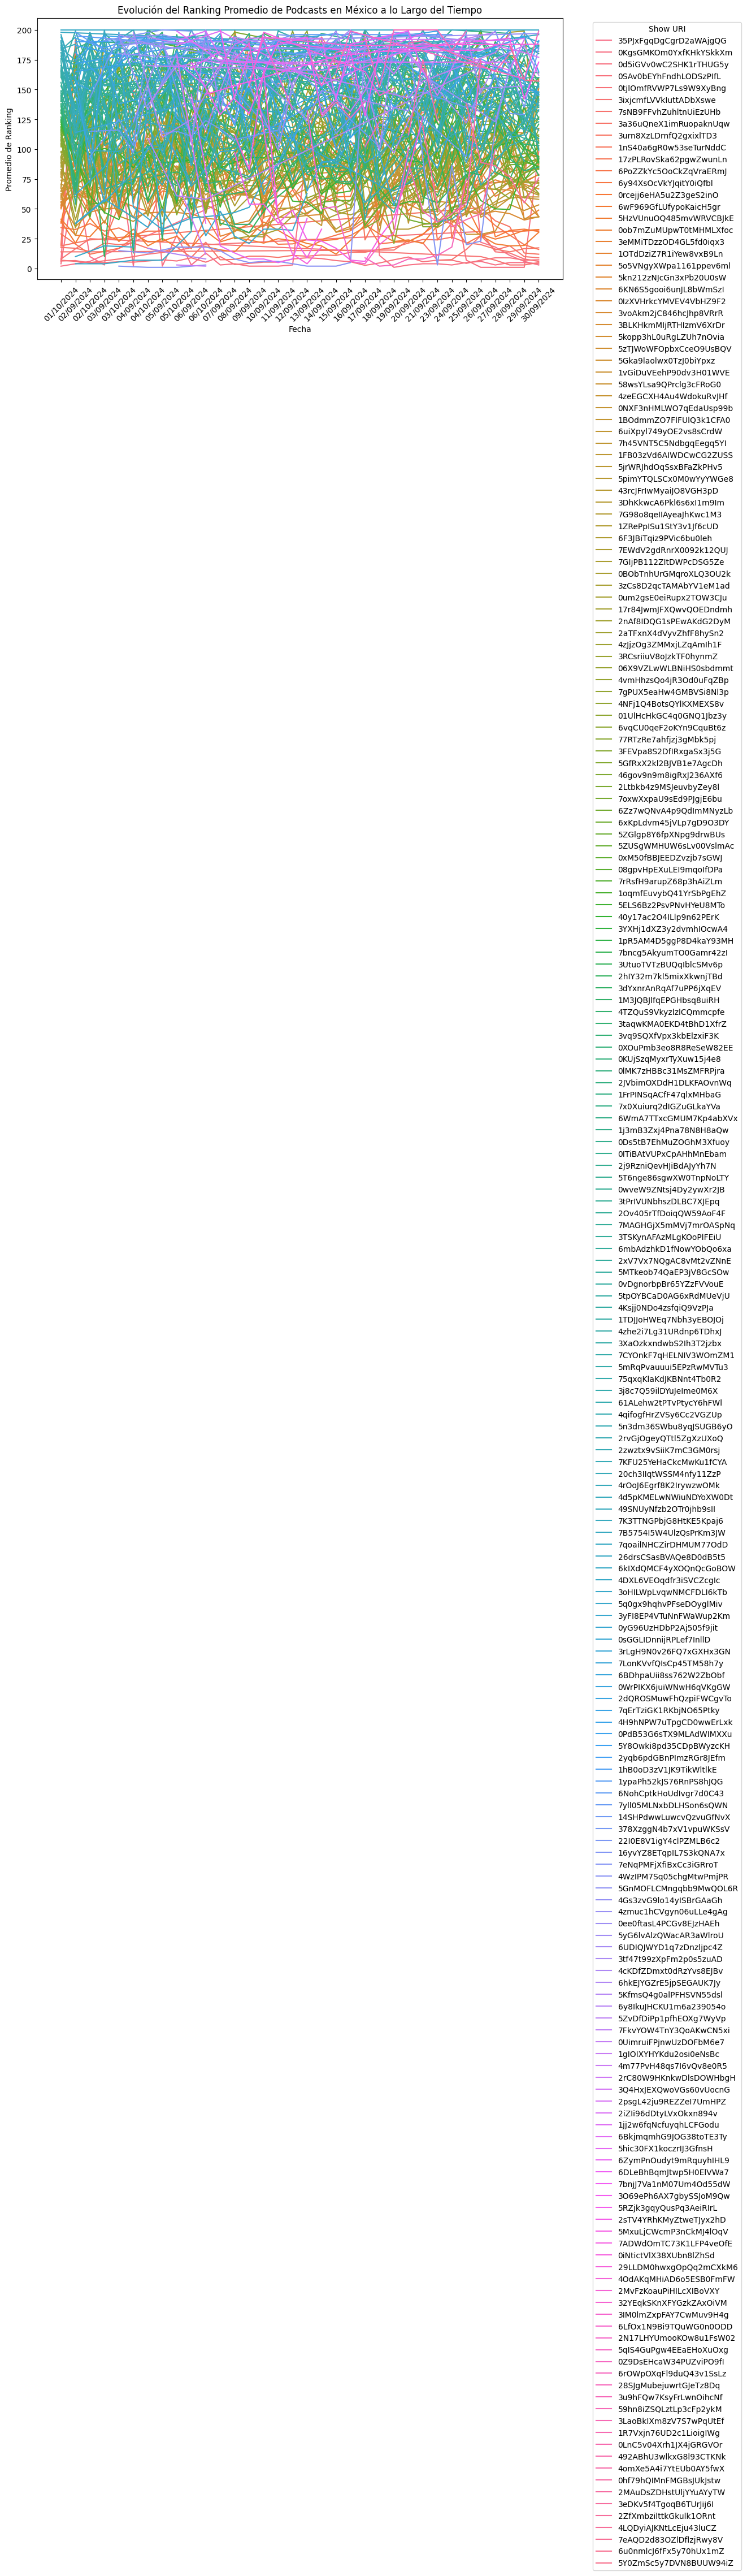

In [19]:
#Visualización de tendencias de ranking a lo largo del tiempo todo mx
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir el DataFrame a pandas para la visualización todo mx
rank_time_series_pd = rank_time_series.toPandas()

# Graficar la evolución de los rankings de los podcasts
plt.figure(figsize=(12, 6))
sns.lineplot(data=rank_time_series_pd, x="date", y="avg_rank", hue="showUri")
plt.title("Evolución del Ranking Promedio de Podcasts en México a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Promedio de Ranking")
plt.xticks(rotation=45)
plt.legend(title='Show URI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


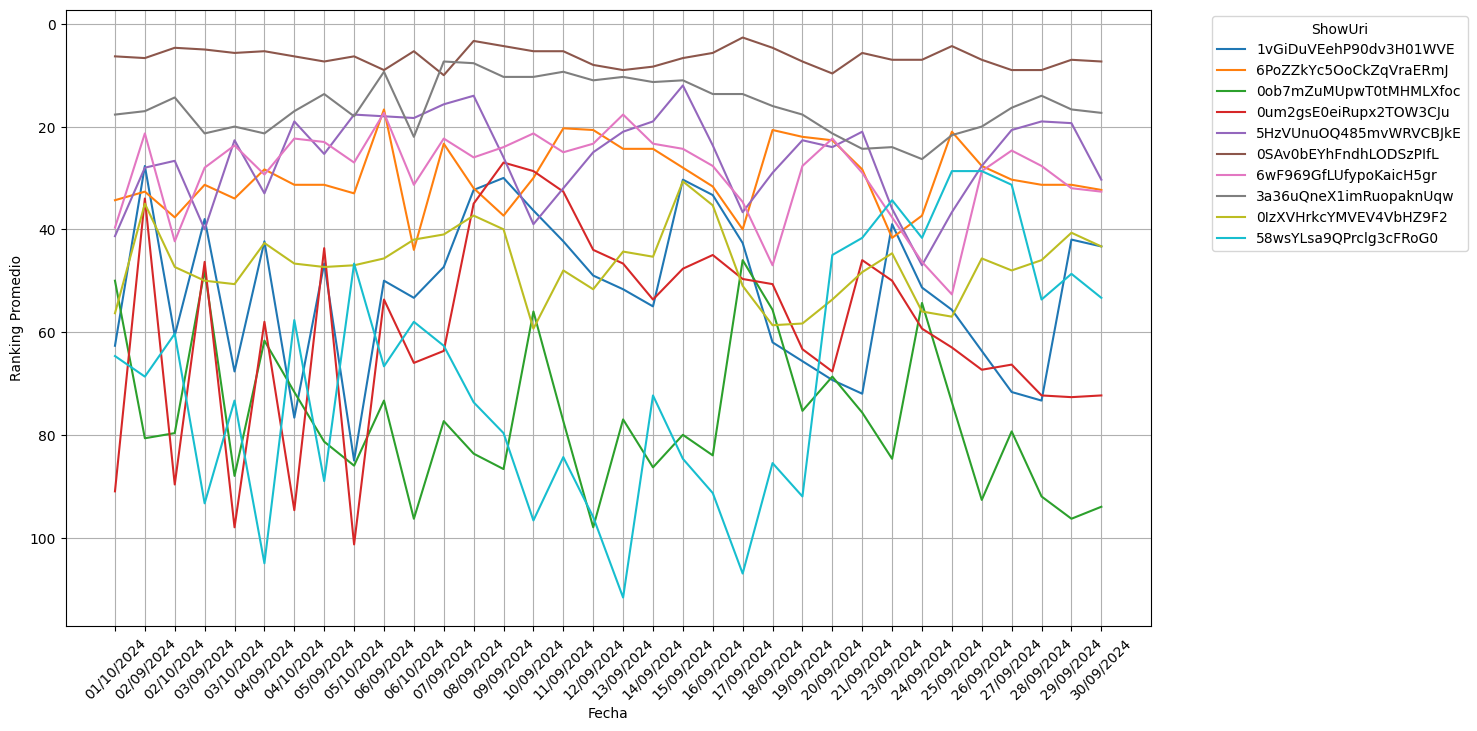

In [41]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

#Contar cuántas veces aparece cada showUri
show_frequency = df_mx.groupBy("showUri").agg(F.count("showUri").alias("count")).orderBy(F.col("count").desc())

# Filtrar los 10 showUri que más aparecen
top_10_shows = show_frequency.limit(10)

#Filtrar df_mx solo con los 10 showUri más frecuentes
df_top_10_shows = df_mx.join(top_10_shows, on="showUri", how="inner")

#Calcular el promedio de ranking por fecha para esos 10 showUri
rank_by_date = df_top_10_shows.groupBy("date", "showUri").agg(F.avg("rank").alias("avg_rank"))

#Ordenar por fecha para la visualización
rank_by_date = rank_by_date.orderBy("date")

#Convertir a Pandas para facilitar la visualización
rank_by_date_pd = rank_by_date.toPandas()

# Graficar la evolución de los rankings
plt.figure(figsize=(14, 8))
sns.lineplot(data=rank_by_date_pd, x="date", y="avg_rank", hue="showUri", palette="tab10")
plt.gca().invert_yaxis()  # Invertir el eje Y para que los rangos más bajos estén arriba

plt.xlabel("Fecha")
plt.ylabel("Ranking Promedio")
plt.legend(title="ShowUri", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()



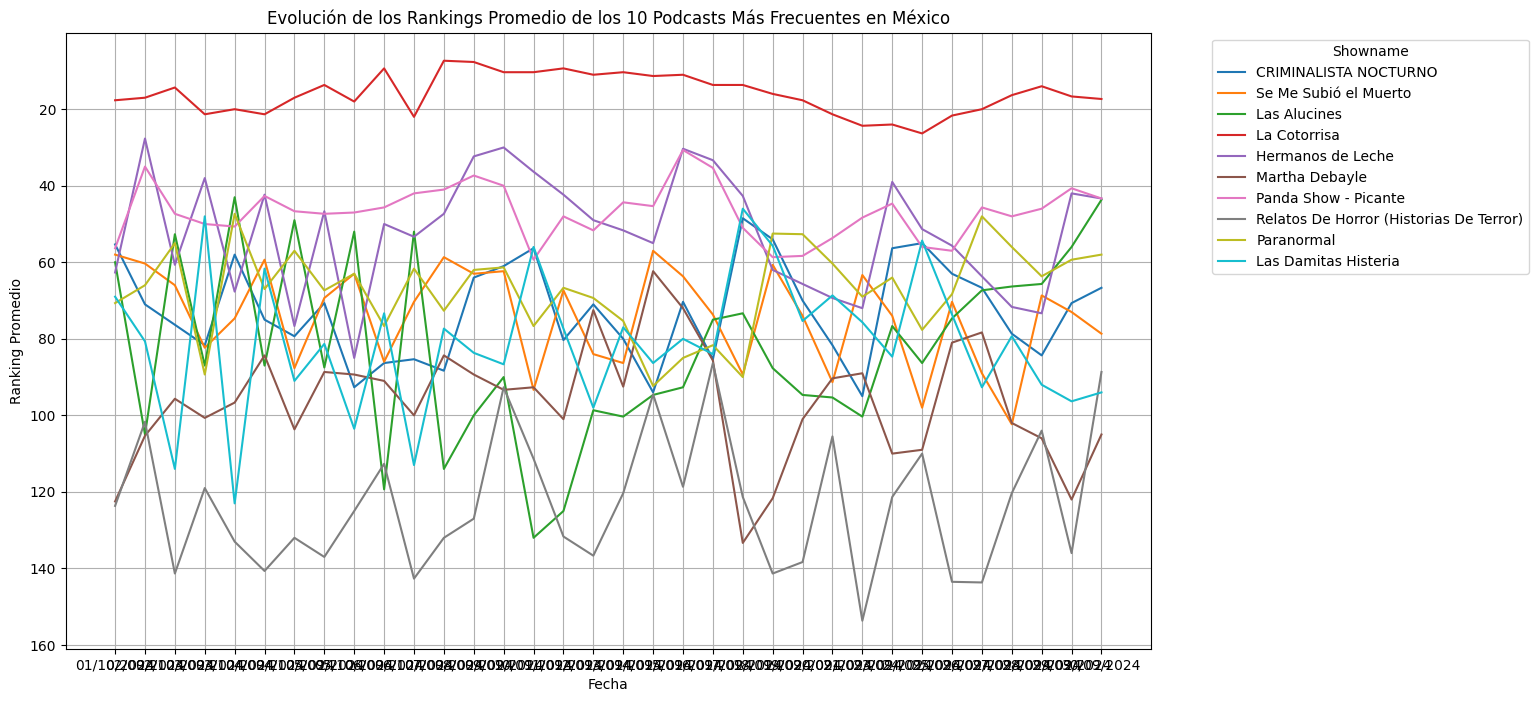

In [21]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Contar cuántas veces aparece cada showname
show_frequency = df_mx.groupBy("showname").agg(F.count("showname").alias("count")).orderBy(F.col("count").desc())

# Filtrar los 10 showname que más aparecen
top_10_shows = show_frequency.limit(10)

# Filtrar df_mx solo con los 10 showname más frecuentes
df_top_10_shows = df_mx.join(top_10_shows, on="showname", how="inner")

# Calcular el promedio de ranking por fecha para esos 10 showname
rank_by_date = df_top_10_shows.groupBy("date", "showname").agg(F.avg("rank").alias("avg_rank"))

# Ordenar por fecha para la visualización
rank_by_date = rank_by_date.orderBy("date")

# Convertir a Pandas para facilitar la visualización
rank_by_date_pd = rank_by_date.toPandas()

# Graficar la evolución de los rankings
plt.figure(figsize=(14, 8))
sns.lineplot(data=rank_by_date_pd, x="date", y="avg_rank", hue="showname", palette="tab10")
plt.gca().invert_yaxis()  # Invertir el eje Y para que los rangos más bajos estén arriba
plt.title("Evolución de los Rankings Promedio de los 10 Podcasts Más Frecuentes en México")
plt.xlabel("Fecha")
plt.ylabel("Ranking Promedio")
plt.legend(title="Showname", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


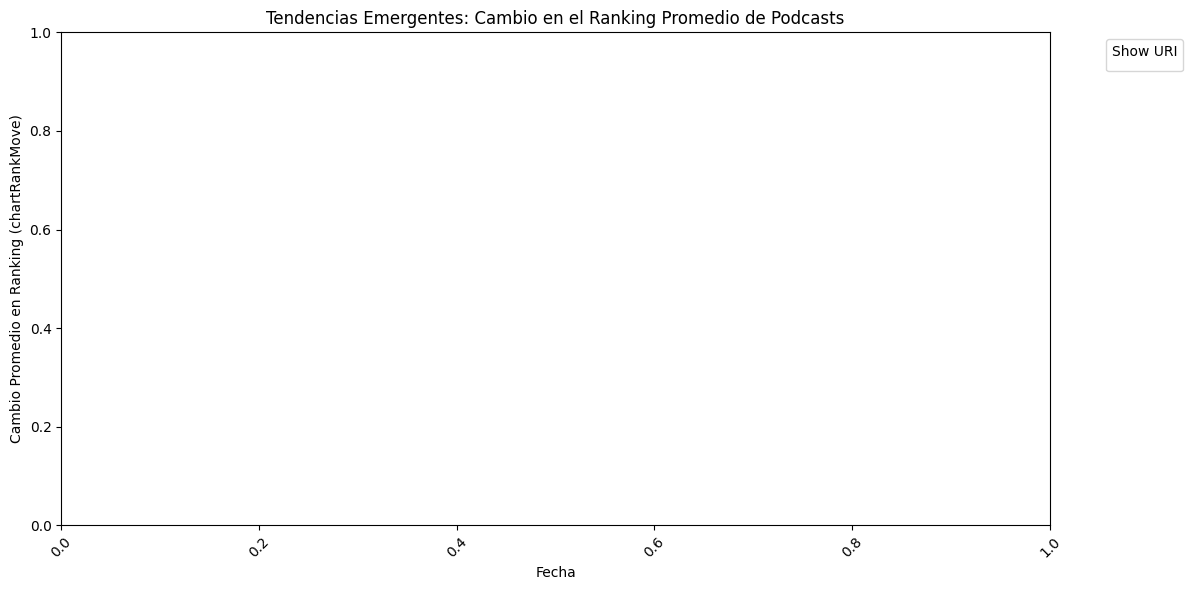

In [22]:
# Graficar el cambio en el ranking (chartRankMove) de los podcasts a lo largo del tiempo
fast_moving_trends_pd = fast_moving_trends.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=fast_moving_trends_pd, x="date", y="avg_chartRankMove", hue="showUri")
plt.title("Tendencias Emergentes: Cambio en el Ranking Promedio de Podcasts")
plt.xlabel("Fecha")
plt.ylabel("Cambio Promedio en Ranking (chartRankMove)")
plt.xticks(rotation=45)
plt.legend(title='Show URI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
##no hay tendencias emergentes de septiembre a octubre

In [23]:
from pyspark.sql import functions as F

# Agrupar por 'showname' y contar las ocurrencias de cada uno
df_mx_repc = df_mx.groupBy('showname').agg(F.count('*').alias('repetition_count'))

# Unir esta nueva columna con el DataFrame original
df_mx = df_mx.join(df_mx_repc, on='showname', how='left')

# Mostrar el DataFrame con la nueva columna
df_mx.show(10, truncate=False)

+-------------------------+----------+----+------+-------------+----------------------+----------------------+------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

                   rank  durationms  explicit  showmediatype
rank           1.000000   -0.372945 -0.187154       0.112484
durationms    -0.372945    1.000000  0.205484      -0.092472
explicit      -0.187154    0.205484  1.000000      -0.223845
showmediatype  0.112484   -0.092472 -0.223845       1.000000


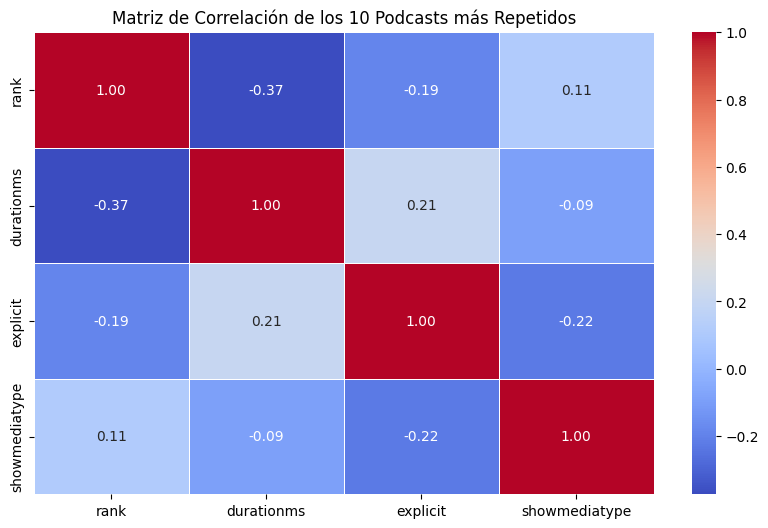

In [24]:
from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar y obtener los 10 podcasts más repetidos
repetition_count = (
    df_mx.groupBy('showname')
    .agg(F.count('*').alias('repetition_count'))
    .orderBy(F.col('repetition_count').desc())  # Ordenar de mayor a menor repetición
)

top_10_repeated_podcasts = repetition_count.limit(10)

#
top_10_shownames = [row['showname'] for row in top_10_repeated_podcasts.collect()]
df_top_10 = df_mx.filter(df_mx['showname'].isin(top_10_shownames))

# Transformar  'explicit' y 'showmediatype'
df_top_10_transformed = df_top_10.withColumn(
    'explicit',
    F.when(df_top_10['explicit'] == 'TRUE', 1).otherwise(0)
).withColumn(
    'showmediatype',
    F.when(df_top_10['showmediatype'] == 'audio', 0).when(df_top_10['showmediatype'] == 'mixed', 1).otherwise(0)
)

# Seleccionar las columnas numéricas para la correlación
df_top_10_numeric = df_top_10_transformed.select('rank', 'durationms', 'explicit', 'showmediatype')

# Convertir el DataFrame de Spark a Pandas
df_top_10_pd = df_top_10_numeric.toPandas()

# Limpiar las columnas numéricas, forzando la conversión y reemplazando cualquier valor no numérico por NaN
df_top_10_pd['rank'] = pd.to_numeric(df_top_10_pd['rank'], errors='coerce')
df_top_10_pd['durationms'] = pd.to_numeric(df_top_10_pd['durationms'], errors='coerce')
df_top_10_pd['explicit'] = pd.to_numeric(df_top_10_pd['explicit'], errors='coerce')
df_top_10_pd['showmediatype'] = pd.to_numeric(df_top_10_pd['showmediatype'], errors='coerce')

# Calcular la matriz de correlación solo con las columnas numéricas
correlation_matrix = df_top_10_pd.corr()
print(correlation_matrix)

# matriz de correlación con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación de los 10 Podcasts más Repetidos')
plt.show()


In [25]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Define df_regression
df_regression = df_mx.select('rank', 'durationms', 'explicit', 'showmediatype')

# revisar tipo de columnas
df_regression = df_regression.withColumn('durationms', col('durationms').cast('float')) \
                             .withColumn('explicit', col('explicit').cast('int')) \
                             .withColumn('showmediatype', col('showmediatype').cast('int')) \
                             .fillna(0, subset=['durationms', 'explicit', 'showmediatype', 'rank']) # Rellenar valores nulos con 0



if 'features' in df_regression.columns:
    df_regression = df_regression.drop('features')

# Crear el vector de características
assembler = VectorAssembler(inputCols=['durationms', 'explicit', 'showmediatype'], outputCol="features")
df_regression = assembler.transform(df_regression)

if 'scaled_features' in df_regression.columns:
    df_regression = df_regression.drop('scaled_features')

# Escalar el vector de características
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True) # Asegurar withMean=True y withStd=True
scaler_model = scaler.fit(df_regression) #Ajustar el scaler solo una vez
df_regression = scaler_model.transform(df_regression)  #Transformar el dataframe


# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = df_regression.randomSplit([0.8, 0.2], seed=1234)

# Crear el modelo Random Forest
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='rank', numTrees=100)

# Entrenar el modelo
rf_model = rf.fit(train_data)

# Hacer predicciones
predictions = rf_model.transform(test_data)

# Evaluar el modelo usando RMSE
evaluator_rmse = RegressionEvaluator(labelCol="rank", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) = {rmse}")

# Evaluar el modelo usando R2
evaluator_r2 = RegressionEvaluator(labelCol="rank", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R2 = {r2}")

# Mostrar las primeras filas de las predicciones
predictions.select("rank", "prediction").show(5)


Root Mean Squared Error (RMSE) = 57.95708218239325
R2 = 0.04081327337547247
+----+------------------+
|rank|        prediction|
+----+------------------+
|   1| 92.46768921559813|
|   1|104.40767025171813|
|   2| 64.77873966018389|
|   2|104.40767025171813|
|   2|104.40767025171813|
+----+------------------+
only showing top 5 rows



In [26]:
df_regression.select("rank", "durationms", "explicit", "showmediatype").summary().show()

+-------+-----------------+-----------------+-----------------+-----------------+
|summary|             rank|       durationms|         explicit|    showmediatype|
+-------+-----------------+-----------------+-----------------+-----------------+
|  count|             6800|             6800|             6800|             6800|
|   mean|            100.5|3432377.222647059|46725.03455882353|38027.13661764706|
| stddev|57.73855086439203|3971989.652684389|805472.0743710931|435270.8546881471|
|    min|                1|              0.0|                0|                0|
|    25%|               50|         995918.0|                0|                0|
|    50%|              100|        2694421.0|                0|                0|
|    75%|              150|        4897281.0|                0|                0|
|    max|              200|      4.2349156E7|         29229322|          6071823|
+-------+-----------------+-----------------+-----------------+-----------------+



In [27]:
from pyspark.sql import functions as F

df_regression = df_regression.withColumn(
    'explicit',
    F.when(df_regression['explicit'] == 'TRUE', 1).otherwise(0)
).withColumn(
    'showmediatype',
    F.when(df_regression['showmediatype'] == 'audio', 0)
     .when(df_regression['showmediatype'] == 'mixed', 1)
     .otherwise(0)
)

df_regression.select("explicit").distinct().show()
df_regression.select("showmediatype").distinct().show()

+--------+
|explicit|
+--------+
|       0|
+--------+

+-------------+
|showmediatype|
+-------------+
|            0|
+-------------+



                        rank  durationms  explicit  showmediatype  \
rank                1.000000   -0.372945 -0.187154       0.112484   
durationms         -0.372945    1.000000  0.205484      -0.092472   
explicit           -0.187154    0.205484  1.000000      -0.223845   
showmediatype       0.112484   -0.092472 -0.223845       1.000000   
is_playable         0.135844         NaN  0.116310       0.219090   
showtotal_episodes  0.272683   -0.364061  0.202550      -0.571239   

                    is_playable  showtotal_episodes  
rank                   0.135844            0.272683  
durationms                  NaN           -0.364061  
explicit               0.116310            0.202550  
showmediatype          0.219090           -0.571239  
is_playable            1.000000                 NaN  
showtotal_episodes          NaN            1.000000  


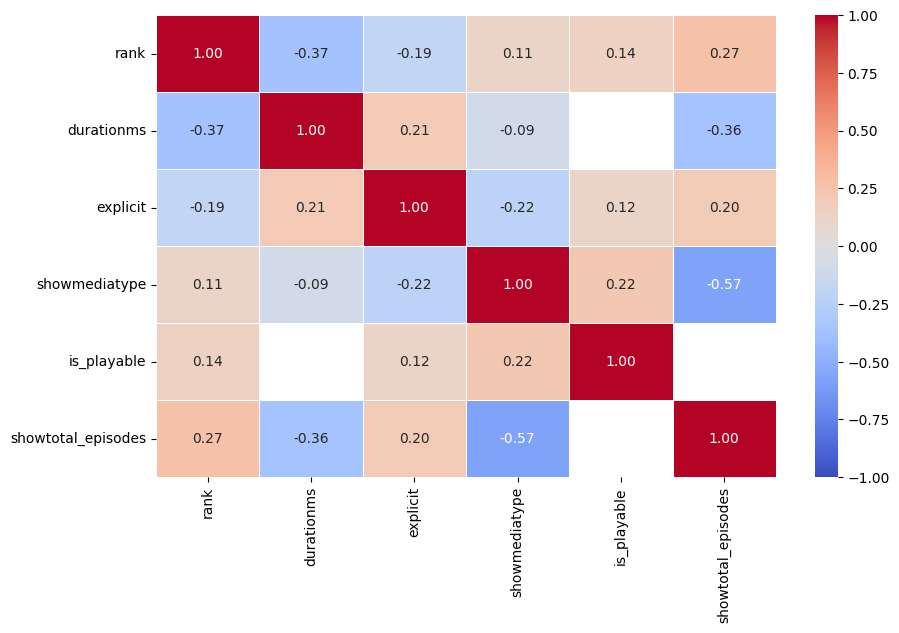

In [40]:
from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lo mismo pero con más variables
#Agrupar y obtener los 10 podcasts más repetidos
repetition_count = (
    df_mx.groupBy('showname')
    .agg(F.count('*').alias('repetition_count'))
    .orderBy(F.col('repetition_count').desc())  # Ordenar de mayor a menor repetición
)

# Filtrar los 10 podcasts más repetidos
top_10_repeated_podcasts = repetition_count.limit(10)

# solo incluir los 10 podcasts más repetidos
top_10_shownames = [row['showname'] for row in top_10_repeated_podcasts.collect()]
df_top_10 = df_mx.filter(df_mx['showname'].isin(top_10_shownames))

# Transformar las columnas 'explicit', 'showmediatype', 'is_externally_hosted', 'is_playable', y 'showtotal_episodes'
df_top_10_transformed = df_top_10.withColumn(
    'explicit',
    F.when(df_top_10['explicit'] == 'TRUE', 1).otherwise(0)
).withColumn(
    'showmediatype',
    F.when(df_top_10['showmediatype'] == 'audio', 0).when(df_top_10['showmediatype'] == 'mixed', 1).otherwise(0)
).withColumn(
    'is_externally_hosted',
    F.when(df_top_10['is_externally_hosted'] == 'TRUE', 1).otherwise(0)
).withColumn(
    'is_playable',
    F.when(df_top_10['is_playable'] == 'TRUE', 1).otherwise(0)
).withColumn(
    'showtotal_episodes',
    F.col('showtotal_episodes').cast('int')  # Asegurarse de que 'showtotal_episodes' es un número
)

# Seleccionar las columnas numéricas para la correlación
df_top_10_numeric = df_top_10_transformed.select(
    'rank', 'durationms', 'explicit', 'showmediatype', 'is_playable', 'showtotal_episodes'
)

# Convertir el DataFrame de Spark a Pandas
df_top_10_pd = df_top_10_numeric.toPandas()

# Limpiar las columnas numéricas
df_top_10_pd['rank'] = pd.to_numeric(df_top_10_pd['rank'], errors='coerce')
df_top_10_pd['durationms'] = pd.to_numeric(df_top_10_pd['durationms'], errors='coerce')
df_top_10_pd['explicit'] = pd.to_numeric(df_top_10_pd['explicit'], errors='coerce')
df_top_10_pd['showmediatype'] = pd.to_numeric(df_top_10_pd['showmediatype'], errors='coerce')

df_top_10_pd['is_playable'] = pd.to_numeric(df_top_10_pd['is_playable'], errors='coerce')
df_top_10_pd['showtotal_episodes'] = pd.to_numeric(df_top_10_pd['showtotal_episodes'], errors='coerce')

# matriz de correlación solo con las columnas numéricas
correlation_matrix = df_top_10_pd.corr()
print(correlation_matrix)

# matriz de correlación con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

plt.show()


In [29]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Convertir las columnas a tipos numéricos
df_top_10_transformed = df_top_10.withColumn(
    'durationms', F.col('durationms').cast('float')
).withColumn(
    'explicit', F.when(F.col('explicit') == 'TRUE', 1).otherwise(0).cast('int')
).withColumn(
    'showmediatype', F.when(F.col('showmediatype') == 'audio', 0)
    .when(F.col('showmediatype') == 'mixed', 1).otherwise(0).cast('int')
).withColumn(
    'is_playable', F.when(F.col('is_playable') == 'TRUE', 1).otherwise(0).cast('int')
).withColumn(
    'showtotal_episodes', F.col('showtotal_episodes').cast('int')
)

# Rellenar valores nulos con 0
df_top_10_transformed = df_top_10_transformed.fillna({
    'durationms': 0,
    'explicit': 0,
    'showmediatype': 0,
    'is_playable': 0,
    'showtotal_episodes': 0
})


df_top_10_transformed.printSchema()

#  columnas de características
feature_columns = ['durationms', 'explicit', 'showmediatype', 'is_playable', 'showtotal_episodes']

#  VectorAssembler para combinar las columnas en un solo vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transformar el dataframe original para agregar la columna 'features'
df_top_10_transformed = assembler.transform(df_top_10_transformed)

# Definir el modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="rank")

#  Ajustar el modelo a los datos
train_data, test_data = df_top_10_transformed.randomSplit([0.8, 0.2], seed=1234)

lr_model = lr.fit(train_data)

# predicciones en el conjunto de prueba
predictions = lr_model.transform(test_data)

# Evaluar el modelo
from pyspark.ml.evaluation import RegressionEvaluator

# calcular el RMSE
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="rank", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluamos R2
r2 = lr_model.summary.r2
print(f"R-squared (R²): {r2}")

# print
print("Coeficientes del modelo de regresión:")
print(f"Intercepto: {lr_model.intercept}")
for idx, col in enumerate(feature_columns):
    print(f"{col}: {lr_model.coefficients[idx]}")


root
 |-- showname: string (nullable = true)
 |-- date: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- chartRankMove: string (nullable = true)
 |-- episodeUri: string (nullable = true)
 |-- showUri: string (nullable = true)
 |-- episodeName: string (nullable = true)
 |-- description: string (nullable = true)
 |-- showdescription: string (nullable = true)
 |-- durationms: float (nullable = false)
 |-- explicit: integer (nullable = false)
 |-- is_externally_hosted: string (nullable = true)
 |-- is_playable: integer (nullable = false)
 |-- language: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- releasedate: string (nullable = true)
 |-- showexplicit: string (nullable = true)
 |-- showhref: string (nullable = true)
 |-- showis_externally_hosted: string (nullable = true)
 |-- showmediatype: integer (nullable = false)
 |-- showtotal_episodes: integer (nullable = false)
 |-- long_episode: boolean (nullable = fa

In [30]:
from pyspark.ml.regression import LinearRegression

# modelo de regresión Lasso (L1 regularization)
lasso_lr = LinearRegression(featuresCol='features', labelCol='rank', regParam=0.1, elasticNetParam=1.0)

# ajustar el modelo con el conjunto de entrenamiento
lasso_lr_model = lasso_lr.fit(train_data)

# realizar predicciones
lasso_predictions = lasso_lr_model.transform(test_data)

# evaluar el modelo
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="rank", predictionCol="prediction", metricName="rmse")

# calcular el RMSE
lasso_rmse = evaluator.evaluate(lasso_predictions)
print(f"Root Mean Squared Error (RMSE) Lasso: {lasso_rmse}")

# R2
lasso_r2 = lasso_lr_model.summary.r2
print(f"R-squared (R²) Lasso: {lasso_r2}")

# print
print("Coeficientes del modelo Lasso:")
print(f"Intercepto: {lasso_lr_model.intercept}")
for idx, col in enumerate(feature_columns):
    print(f"{col}: {lasso_lr_model.coefficients[idx]}")


Root Mean Squared Error (RMSE) Lasso: 40.88392261607492
R-squared (R²) Lasso: 0.22666299851716998
Coeficientes del modelo Lasso:
Intercepto: 52.17706886213694
durationms: -3.165936200801114e-06
explicit: -26.93652158851413
showmediatype: 24.592481070105073
is_playable: 13.1465008181923
showtotal_episodes: 0.027894249883206153


In [31]:
# modelo de regresión Ridge L2 regularization
ridge_lr = LinearRegression(featuresCol='features', labelCol='rank', regParam=0.1, elasticNetParam=0.0)

# Ajustar el modelo con el conjunto de entrenamiento
ridge_lr_model = ridge_lr.fit(train_data)

# Realizar predicciones
ridge_predictions = ridge_lr_model.transform(test_data)

# Evaluar el modelo
ridge_rmse = evaluator.evaluate(ridge_predictions)
print(f"Root Mean Squared Error (RMSE) Ridge: {ridge_rmse}")

# R2
ridge_r2 = ridge_lr_model.summary.r2
print(f"R-squared (R²) Ridge: {ridge_r2}")

# print
print("Coeficientes del modelo Ridge:")
print(f"Intercepto: {ridge_lr_model.intercept}")
for idx, col in enumerate(feature_columns):
    print(f"{col}: {ridge_lr_model.coefficients[idx]}")


Root Mean Squared Error (RMSE) Ridge: 40.88079657879816
R-squared (R²) Ridge: 0.22668635127450498
Coeficientes del modelo Ridge:
Intercepto: 51.889840365138205
durationms: -3.2154736165915115e-06
explicit: -27.156089055148485
showmediatype: 24.71088028538231
is_playable: 13.624235720417097
showtotal_episodes: 0.02795263748515266


In [32]:
from pyspark.ml.feature import PolynomialExpansion, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

# características
feature_columns = ['durationms', 'explicit', 'showmediatype', 'is_playable', 'showtotal_episodes']

# ensamblador de características
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")

# Expansión polinómica
poly_expansion = PolynomialExpansion(inputCol="assembled_features", outputCol="polynomial_features", degree=2)

# Regresión Lineal
lr = LinearRegression(featuresCol="polynomial_features", labelCol="rank")

# Pipeline para transformar y entrenar el modelo
pipeline = Pipeline(stages=[assembler, poly_expansion, lr])

# Entrenar el modelo
model = pipeline.fit(train_data)

# predicciones
predictions = model.transform(test_data)

# Evaluar el rendimiento
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="rank", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Root Mean Squared Error (RMSE): 40.52395916606726
R-squared (R²): 0.23375328227961067


In [33]:
from pyspark.ml.regression import DecisionTreeRegressor

#  Árbol de Decisión
dt = DecisionTreeRegressor(featuresCol="features", labelCol="rank")

# Ajustar el modelo
dt_model = dt.fit(train_data)

# Realizar predicciones
dt_predictions = dt_model.transform(test_data)

# Evaluar el rendimiento
rmse_dt = evaluator.evaluate(dt_predictions)
r2_dt = evaluator.evaluate(dt_predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE) Árbol de Decisión: {rmse_dt}")
print(f"R-squared (R²) Árbol de Decisión: {r2_dt}")


Root Mean Squared Error (RMSE) Árbol de Decisión: 37.33153084264521
R-squared (R²) Árbol de Decisión: 0.3497258536973047


In [34]:
from pyspark.ml.regression import RandomForestRegressor

# Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="rank")

# Ajustar el modelo
rf_model = rf.fit(train_data)

# Realizar predicciones
rf_predictions = rf_model.transform(test_data)

# Evaluar el rendimiento
rmse_rf = evaluator.evaluate(rf_predictions)
r2_rf = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE) Random Forest: {rmse_rf}")
print(f"R-squared (R²) Random Forest: {r2_rf}")


Root Mean Squared Error (RMSE) Random Forest: 38.23932209492889
R-squared (R²) Random Forest: 0.31771588816805785


In [35]:
from pyspark.ml.regression import GBTRegressor

# modelo de Gradient Boosting
gbt = GBTRegressor(featuresCol="features", labelCol="rank")

# Ajustar el modelo
gbt_model = gbt.fit(train_data)

# Realizar predicciones
gbt_predictions = gbt_model.transform(test_data)

# Evaluar el rendimiento
rmse_gbt = evaluator.evaluate(gbt_predictions)
r2_gbt = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE) Gradient Boosting: {rmse_gbt}")
print(f"R-squared (R²) Gradient Boosting: {r2_gbt}")


Root Mean Squared Error (RMSE) Gradient Boosting: 36.76355783498815
R-squared (R²) Gradient Boosting: 0.3693622599257379


In [36]:
import xgboost as xgb
from pyspark.sql.functions import col

# Convertir los datos para XGBoost
train_data_xgb = train_data.select([col(c).cast("double") for c in feature_columns + ["rank"]])
test_data_xgb = test_data.select([col(c).cast("double") for c in feature_columns + ["rank"]])

# matrices DMatrix de XGBoost
train_matrix = xgb.DMatrix(train_data_xgb.select(feature_columns).collect(), label=train_data_xgb.select("rank").collect())
test_matrix = xgb.DMatrix(test_data_xgb.select(feature_columns).collect(), label=test_data_xgb.select("rank").collect())

# Parámetros para el modelo XGBoost
params = {
    "objective": "reg:squarederror",  # Regresión
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

# Entrenar el modelo XGBoost
xgb_model = xgb.train(params, train_matrix, num_boost_round=100)

# Realizar predicciones
xgb_predictions = xgb_model.predict(test_matrix)

# Calcular RMSE
from sklearn.metrics import mean_squared_error
rmse_xgb = mean_squared_error(test_data_xgb.select("rank").collect(), xgb_predictions, squared=False)

print(f"Root Mean Squared Error (RMSE) XGBoost: {rmse_xgb}")
from sklearn.metrics import root_mean_squared_error



Root Mean Squared Error (RMSE) XGBoost: 32.864225674483954


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
